In [11]:
from glob import glob
from torchvision import transforms

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import torch

from CTran.dataloaders.data_utils import image_loader
from CTran.models import CTranModel

# Load CTran model (Cloned from https://github.com/QData/C-Tran)

In [12]:
model = CTranModel(num_labels = 22, use_lmt = True, pos_emb = False, layers = 3, heads = 4, dropout = 0.1, int_loss = 0, no_x_features = False)
model.load_state_dict(torch.load("../EOTW_models/CTran_model.pt")["state_dict"])

model.eval()

# To cuda
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print(f"Model is on {device}")

Model is on cuda


# Define the model parameters

In [13]:
normTransform = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
scale_size = 640
crop_size = 576

testTransform = transforms.Compose([transforms.Resize((scale_size, scale_size)),
                                    transforms.CenterCrop(crop_size),
                                    transforms.ToTensor(),
                                    normTransform])

labels = np.array(["Outfall", "Outfall_Spilling", "Outfall_Aeration", "Outfall_Screen", "Sewage_Litter", "Rubbish", "Obstruction", "Modified_Channel", 
          "Proportion_Modified", "Discolouration", "Discolouration_Outfall", "Aeration", "Aeration_Extent", 
          "Wildlife", "Wildlife_Fish", "Wildlife_Invertebrate", "Wildlife_Birds", "Wildlife_Other", "Algal_Bloom", "Plants", "People", "Sensor"])

In [14]:
# You can change the image_folder to the folder where you have the images
image_folder = "../EOTW_data/labelled/Image Classification/Development_Dataset/Development_Dataset_Images"
demo_imgs = sorted(glob(image_folder + "/*"))

GBR201600000000001.JPG - Predicted labels: Outfall, Outfall_Spilling, Outfall_Screen, Sewage_Litter, Obstruction, Modified_Channel, Proportion_Modified


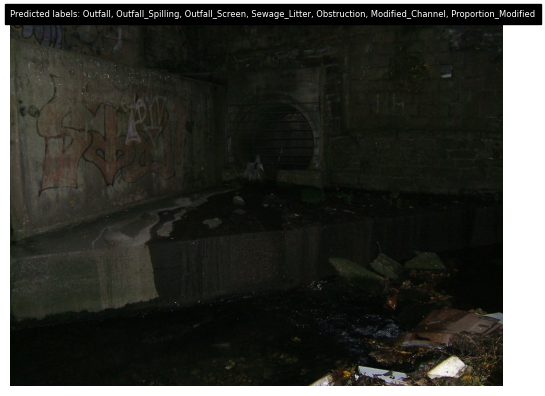

In [22]:
for img_path in demo_imgs:
    img_name = img_path.split("/")[-1]
    img = image_loader(img_path, testTransform)
    img = img.unsqueeze(0)
    
    mask = torch.tensor([[-1.0 for _ in range(22)]])
    
    with torch.no_grad():
        pred, int_pred, attns = model(img.to(device), mask.to(device))
        
        # Multi-label classification
        preds = pred > 0.9
        preds = preds.cpu().numpy()[0]
        print(f"{img_name} - Predicted labels: {', '.join([labels[i] for i in range(len(preds)) if preds[i] == 1])}")
        # print(f"{img_name} - Predicted labels: {preds * 1}, detected labels: {labels[(preds * 1) == 1]}")
        
        image = mpimg.imread(img_path)
        plt.imshow(image)
        plt.axis('off')
        # Add annotations under the image
        plt.text(0, 1, f"Predicted labels: {', '.join([labels[i] for i in range(len(preds)) if preds[i] == 1])}", fontsize=6, color='white', backgroundcolor='black')
        
        break